# Telepass Insurance Prediction Models
## Model 1: Logistic Regression

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, precision_recall_curve
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

## Load Datasets

In [3]:
# Load the datasets
print("Loading datasets...")
# Adjust path relative to the notebook location (inside the models/1-logistic-regression directory)
insurance_quotes = pd.read_csv('../../data/insurance_quotes.csv', sep=';')
transactions = pd.read_csv('../../data/transactions.csv', sep=';')

# Display basic information about the datasets
print("Insurance Quotes Dataset:")
print("Shape: {}".format(insurance_quotes.shape))
print(insurance_quotes.head())

print("Transactions Dataset:")
print("Shape: {}".format(transactions.shape))
print(transactions.head())

Loading datasets...
Insurance Quotes Dataset:
Shape: (36173, 40)
   client_id  quotation_id  driving_type car_immatriculation_date  \
0      23789          3649  more_than_26                20.7.2011   
1      10133         28552  more_than_26                 1.3.2007   
2      20785         31958  more_than_26                30.8.2017   
3      33892         27614  more_than_26                25.7.2017   
4      34153          1529  more_than_26               19.12.2006   

          car_brand       car_model insurance_expires_at birth_date gender  \
0              FORD           C-MAX            12.6.2020        NaN    NaN   
1  FIAT - INNOCENTI      FIAT CROMA            22.1.2020        NaN    NaN   
2            NISSAN  NISSAN QASHQAI            2.10.2020  22.9.1992      M   
3  FIAT - INNOCENTI      FIAT PANDA            25.7.2020   9.2.1996      M   
4  FIAT - INNOCENTI      FIAT PUNTO           13.10.2020   8.1.2000      M   

  county base_subscription base_type pay_subscripti

## Check Missing Values

In [4]:
# Check for missing values
print("Missing values in Insurance Quotes Dataset:")
print(insurance_quotes.isnull().sum())

print("Missing values in Transactions Dataset:")
print(transactions.isnull().sum())

Missing values in Insurance Quotes Dataset:
client_id                       0
quotation_id                    0
driving_type                    0
car_immatriculation_date     1710
car_brand                       0
car_model                       0
insurance_expires_at           45
birth_date                  13643
gender                      13581
county                       2827
base_subscription               0
base_type                       0
pay_subscription            26047
pay_cancellation            26047
premium_subscription        13042
premium_cancellation        13042
operating_system             1326
policy_quoted_at                0
broker_id                       0
issued                          0
guarantees_purchased        26059
guarantees_available            0
roadside_assistance             0
driver_injury                 743
basic_coverage                  0
legal_protection              762
waive_right_compensation    15288
uninsured_vehicles          33025
prot

## Preprocessing Functions

In [5]:
# Define a function to preprocess the insurance quotes dataset
def preprocess_insurance_quotes(df):
    """
    Preprocess the insurance quotes dataset for modeling.
    """
    # Make a copy of the dataframe
    df_processed = df.copy()
    
    # Convert categorical variables to appropriate types
    
    # Handle date columns
    date_columns = ['car_immatriculation_date', 'insurance_expires_at', 'birth_date', 
                   'base_subscription', 'pay_subscription', 'pay_cancellation',
                   'premium_subscription', 'premium_cancellation', 'policy_quoted_at']
    
    for col in date_columns:
        if col in df_processed.columns:
            try:
                df_processed[col] = pd.to_datetime(df_processed[col], errors='coerce')
            except:
                print("Could not convert {} to datetime.".format(col))
    
    # Handle the target variable - properly convert 'TRUE'/'FALSE' to 1/0
    if 'issued' in df_processed.columns:
        df_processed['issued'] = df_processed['issued'].map({True: 1, 'TRUE': 1, False: 0, 'FALSE': 0})
    
    # Convert numeric columns with comma separators
    numeric_columns = ['driver_injury', 'basic_coverage', 'legal_protection', 
                       'waive_right_compensation', 'uninsured_vehicles', 
                       'protected_bonus', 'windows', 'natural_events', 
                       'theft_fire', 'kasko', 'license_revoked', 
                       'collision', 'vandalism', 'key_loss', 
                       'price_sale', 'price_full', 'discount_percent']
    
    for col in numeric_columns:
        if col in df_processed.columns:
            df_processed[col] = df_processed[col].astype(str).str.replace(',', '.').astype(float, errors='ignore')
    
    # Create derived features
    # Calculate age at policy quote time
    if 'birth_date' in df_processed.columns and 'policy_quoted_at' in df_processed.columns:
        mask = ~df_processed['birth_date'].isna() & ~df_processed['policy_quoted_at'].isna()
        df_processed.loc[mask, 'age'] = (df_processed.loc[mask, 'policy_quoted_at'] - 
                                         df_processed.loc[mask, 'birth_date']).dt.days / 365.25
    
    # Calculate car age at policy quote time
    if 'car_immatriculation_date' in df_processed.columns and 'policy_quoted_at' in df_processed.columns:
        mask = ~df_processed['car_immatriculation_date'].isna() & ~df_processed['policy_quoted_at'].isna()
        df_processed.loc[mask, 'car_age'] = (df_processed.loc[mask, 'policy_quoted_at'] - 
                                            df_processed['car_immatriculation_date']).dt.days / 365.25
    
    # Telepass membership duration
    if 'base_subscription' in df_processed.columns and 'policy_quoted_at' in df_processed.columns:
        mask = ~df_processed['base_subscription'].isna() & ~df_processed['policy_quoted_at'].isna()
        df_processed.loc[mask, 'telepass_membership_years'] = (df_processed.loc[mask, 'policy_quoted_at'] - 
                                                             df_processed['base_subscription']).dt.days / 365.25
    
    # Flag customers with TelepassPay
    if 'pay_subscription' in df_processed.columns and 'pay_cancellation' in df_processed.columns:
        df_processed['has_telepass_pay'] = 0
        # If they have a pay_subscription but no cancellation or cancellation is far in the future
        mask = (~df_processed['pay_subscription'].isna() & 
                (df_processed['pay_cancellation'].isna() | 
                 (df_processed['pay_cancellation'] > pd.to_datetime('2025-01-01'))))
        df_processed.loc[mask, 'has_telepass_pay'] = 1
    
    # Flag customers with Telepass Premium
    if 'premium_subscription' in df_processed.columns and 'premium_cancellation' in df_processed.columns:
        df_processed['has_telepass_premium'] = 0
        # If they have a premium_subscription but no cancellation or cancellation is far in the future
        mask = (~df_processed['premium_subscription'].isna() & 
                (df_processed['premium_cancellation'].isna() | 
                 (df_processed['premium_cancellation'] > pd.to_datetime('2025-01-01'))))
        df_processed.loc[mask, 'has_telepass_premium'] = 1
    
    # Count available guarantees
    if 'guarantees_available' in df_processed.columns:
        df_processed['num_guarantees_available'] = df_processed['guarantees_available'].str.count('-') + 1
    
    return df_processed

# Define a function to preprocess the transactions dataset
def preprocess_transactions(df):
    """
    Preprocess the transactions dataset for modeling.
    """
    # Make a copy of the dataframe
    df_processed = df.copy()
    
    # Convert year_month to datetime
    if 'year_month' in df_processed.columns:
        try:
            df_processed['year_month'] = pd.to_datetime(df_processed['year_month'], format='%b.%y', errors='coerce')
        except:
            print("Could not convert year_month to datetime.")
    
    # Handle numerical values
    if 'expenditures' in df_processed.columns:
        df_processed['expenditures'] = df_processed['expenditures'].astype(str).str.replace(',', '.').astype(float)
    
    return df_processed

# Function to create aggregate features per client from transactions
def create_transaction_features(df):
    """
    Aggregate transaction data to create features at the client level.
    """
    # Calculate total transactions and expenditures per client
    client_stats = df.groupby('client_id').agg(
        total_transactions=('number_transactions', 'sum'),
        total_expenditures=('expenditures', 'sum'),
        avg_expenditure_per_transaction=('expenditures', lambda x: x.sum() / df.loc[x.index, 'number_transactions'].sum()),
        num_months_active=('year_month', 'nunique'),
        num_service_types=('service_type', 'nunique')
    )
    
    # Calculate statistics for telepass_pay transactions
    telepass_pay_stats = df[df['telepass_pay'] == 1].groupby('client_id').agg(
        telepass_pay_transactions=('number_transactions', 'sum'),
        telepass_pay_expenditures=('expenditures', 'sum')
    )
    
    # Merge all features
    client_features = client_stats.copy()
    client_features = client_features.join(telepass_pay_stats, how='left')
    
    # Fill NaN values for clients without telepass_pay transactions
    client_features['telepass_pay_transactions'] = client_features['telepass_pay_transactions'].fillna(0)
    client_features['telepass_pay_expenditures'] = client_features['telepass_pay_expenditures'].fillna(0)
    
    # Calculate percentage of telepass_pay transactions
    client_features['telepass_pay_pct'] = client_features['telepass_pay_transactions'] / client_features['total_transactions']
    client_features['telepass_pay_expenditures_pct'] = client_features['telepass_pay_expenditures'] / client_features['total_expenditures']
    
    # Handle division by zero
    client_features.replace([np.inf, -np.inf], np.nan, inplace=True)
    client_features.fillna(0, inplace=True)
    
    # Reset index to make client_id a column
    client_features.reset_index(inplace=True)
    
    return client_features

## Apply Preprocessing and Feature Engineering

In [6]:
# Preprocess the datasets
print("Preprocessing datasets...")
insurance_quotes_processed = preprocess_insurance_quotes(insurance_quotes)
transactions_processed = preprocess_transactions(transactions)

# Display the preprocessed datasets
print("Preprocessed Insurance Quotes Dataset:")
display(insurance_quotes_processed.head()) # Use display for better rendering in notebooks

print("Preprocessed Transactions Dataset:")
display(transactions_processed.head())

Preprocessing datasets...
Preprocessed Insurance Quotes Dataset:


,client_id,quotation_id,driving_type,car_immatriculation_date,car_brand,car_model,insurance_expires_at,birth_date,gender,county,base_subscription,base_type,pay_subscription,pay_cancellation,premium_subscription,premium_cancellation,operating_system,policy_quoted_at,broker_id,issued,guarantees_purchased,guarantees_available,roadside_assistance,driver_injury,basic_coverage,legal_protection,waive_right_compensation,uninsured_vehicles,protected_bonus,windows,natural_events,theft_fire,kasko,license_revoked,collision,vandalism,key_loss,price_sale,price_full,discount_percent,age,car_age,telepass_membership_years,has_telepass_pay,has_telepass_premium,num_guarantees_available
0,23789,3649,more_than_26,2011-07-20,FORD,C-MAX,2020-12-06,NaT,NaN,FC,2019-06-24,FA,NaT,NaT,2020-11-06,NaT,and,2020-03-15,1,0,NaN,Assistenza Stradale - Collisione - Cristalli -...,1,37.50,325.48,28.33,25.30,NaN,NaN,68.10,NaN,22.70,NaN,NaN,121.83,NaN,NaN,325.48,325.48,0.000000,NaN,8.654346,0.725530,0,1,8
1,10133,28552,more_than_26,2007-03-01,FIAT - INNOCENTI,FIAT CROMA,NaT,NaT,NaN,MS,2012-11-12,FA,NaT,NaT,NaT,NaT,and,2020-01-08,1,0,NaN,Assistenza Stradale - Bonus Protetto - Collisi...,1,33.73,271.25,24.43,11.92,NaN,37.04,34.42,NaN,22.70,NaN,NaN,89.99,NaN,NaN,271.25,306.80,0.115874,NaN,12.856947,7.154004,0,0,9
2,20785,31958,more_than_26,2017-08-30,NISSAN,NISSAN QASHQAI,2020-02-10,1992-09-22,M,SA,2019-08-26,FA,2019-08-26,NaT,NaT,NaT,and,2020-04-29,1,0,NaN,Assistenza Stradale - Infortuni del Conducente...,1,36.25,640.84,29.50,25.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,640.84,684.01,0.063113,27.600274,2.663929,0.676249,1,0,5
3,33892,27614,more_than_26,2017-07-25,FIAT - INNOCENTI,FIAT PANDA,NaT,1996-02-09,M,NaN,2017-09-12,FA,NaT,NaT,NaT,NaT,and,2020-03-17,2,0,NaN,Assistenza Stradale - RCA,1,NaN,2185.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2185.38,2204.87,0.008840,24.101300,2.644764,2.510609,0,0,2
4,34153,1529,more_than_26,2006-12-19,FIAT - INNOCENTI,FIAT PUNTO,NaT,2000-01-08,M,CN,2019-08-29,FA,NaT,NaT,NaT,NaT,ios,2020-02-09,1,0,NaN,Assistenza Stradale - Bonus Protetto - Collisi...,1,39.13,207.68,24.72,25.30,NaN,25.45,36.36,NaN,24.34,NaN,NaN,156.11,NaN,NaN,207.68,231.20,0.101730,20.087611,13.141684,0.449008,0,0,9


Preprocessed Transactions Dataset:


,client_id,year_month,service_type,telepass_pay,number_transactions,expenditures
0,20785,2020-05-01,PARCHEGGI/TRAGHETTI,0,1,2.00
1,20785,2019-09-01,PARCHEGGI/TRAGHETTI,0,1,2.00
2,34153,2020-02-01,PARCHEGGI/TRAGHETTI,0,1,3.75
3,21141,2020-01-01,PARCHEGGI/TRAGHETTI,0,1,3.50
4,21141,2020-02-01,PARCHEGGI/TRAGHETTI,0,1,7.00


In [7]:
# Create transaction features
print("Creating transaction features...")
transaction_features = create_transaction_features(transactions_processed)
display(transaction_features.head())

Creating transaction features...


,client_id,total_transactions,total_expenditures,avg_expenditure_per_transaction,num_months_active,num_service_types,telepass_pay_transactions,telepass_pay_expenditures,telepass_pay_pct,telepass_pay_expenditures_pct
0,2,2,615.707998,307.853999,2,1,2.0,615.707998,1.0,1.0
1,3,1,4.200000,4.200000,1,1,0.0,0.000000,0.0,0.0
2,5,1,5.000000,5.000000,1,1,1.0,5.000000,1.0,1.0
3,8,5,27.000000,5.400000,3,1,0.0,0.000000,0.0,0.0
4,10,2,24.700000,12.350000,2,1,0.0,0.000000,0.0,0.0


## Merge Datasets

In [8]:
# Merge the datasets
print("Merging datasets...")
merged_data = insurance_quotes_processed.merge(
    transaction_features, 
    on='client_id', 
    how='left'
)

# Fill missing transaction data for clients without transactions
for col in transaction_features.columns:
    if col != 'client_id':
        merged_data[col] = merged_data[col].fillna(0)

print("Shape of merged data: {}".format(merged_data.shape))
display(merged_data.head())

Merging datasets...
Shape of merged data: (36173, 55)


,client_id,quotation_id,driving_type,car_immatriculation_date,car_brand,car_model,insurance_expires_at,birth_date,gender,county,base_subscription,base_type,pay_subscription,pay_cancellation,premium_subscription,premium_cancellation,operating_system,policy_quoted_at,broker_id,issued,guarantees_purchased,guarantees_available,roadside_assistance,driver_injury,basic_coverage,legal_protection,waive_right_compensation,uninsured_vehicles,protected_bonus,windows,natural_events,theft_fire,kasko,license_revoked,collision,vandalism,key_loss,price_sale,price_full,discount_percent,age,car_age,telepass_membership_years,has_telepass_pay,has_telepass_premium,num_guarantees_available,total_transactions,total_expenditures,avg_expenditure_per_transaction,num_months_active,num_service_types,telepass_pay_transactions,telepass_pay_expenditures,telepass_pay_pct,telepass_pay_expenditures_pct
0,23789,3649,more_than_26,2011-07-20,FORD,C-MAX,2020-12-06,NaT,NaN,FC,2019-06-24,FA,NaT,NaT,2020-11-06,NaT,and,2020-03-15,1,0,NaN,Assistenza Stradale - Collisione - Cristalli -...,1,37.50,325.48,28.33,25.30,NaN,NaN,68.10,NaN,22.70,NaN,NaN,121.83,NaN,NaN,325.48,325.48,0.000000,NaN,8.654346,0.725530,0,1,8,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0
1,10133,28552,more_than_26,2007-03-01,FIAT - INNOCENTI,FIAT CROMA,NaT,NaT,NaN,MS,2012-11-12,FA,NaT,NaT,NaT,NaT,and,2020-01-08,1,0,NaN,Assistenza Stradale - Bonus Protetto - Collisi...,1,33.73,271.25,24.43,11.92,NaN,37.04,34.42,NaN,22.70,NaN,NaN,89.99,NaN,NaN,271.25,306.80,0.115874,NaN,12.856947,7.154004,0,0,9,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0
2,20785,31958,more_than_26,2017-08-30,NISSAN,NISSAN QASHQAI,2020-02-10,1992-09-22,M,SA,2019-08-26,FA,2019-08-26,NaT,NaT,NaT,and,2020-04-29,1,0,NaN,Assistenza Stradale - Infortuni del Conducente...,1,36.25,640.84,29.50,25.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,640.84,684.01,0.063113,27.600274,2.663929,0.676249,1,0,5,2.0,4.00,2.00,2.0,1.0,0.0,0.0,0.0,0.0
3,33892,27614,more_than_26,2017-07-25,FIAT - INNOCENTI,FIAT PANDA,NaT,1996-02-09,M,NaN,2017-09-12,FA,NaT,NaT,NaT,NaT,and,2020-03-17,2,0,NaN,Assistenza Stradale - RCA,1,NaN,2185.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2185.38,2204.87,0.008840,24.101300,2.644764,2.510609,0,0,2,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0
4,34153,1529,more_than_26,2006-12-19,FIAT - INNOCENTI,FIAT PUNTO,NaT,2000-01-08,M,CN,2019-08-29,FA,NaT,NaT,NaT,NaT,ios,2020-02-09,1,0,NaN,Assistenza Stradale - Bonus Protetto - Collisi...,1,39.13,207.68,24.72,25.30,NaN,25.45,36.36,NaN,24.34,NaN,NaN,156.11,NaN,NaN,207.68,231.20,0.101730,20.087611,13.141684,0.449008,0,0,9,1.0,3.75,3.75,1.0,1.0,0.0,0.0,0.0,0.0


## Prepare Data for Modeling

In [9]:
# Check the values in the issued column
print("Values in the issued column:")
print(merged_data['issued'].value_counts(dropna=False))

# Drop rows with NaN in the target variable
print("Removing rows with missing target values...")
merged_data = merged_data.dropna(subset=['issued'])
print("Shape after removing rows with missing target: {}".format(merged_data.shape))

Values in the issued column:
issued
0    26059
1    10114
Name: count, dtype: int64
Removing rows with missing target values...
Shape after removing rows with missing target: (36173, 55)


In [10]:
# Feature selection for the model
print("Selecting features for modeling...")

# Numerical features
numerical_features = [
    'basic_coverage', 'price_sale', 'price_full', 'discount_percent',
    'car_age', 'telepass_membership_years', 'num_guarantees_available',
    'total_transactions', 'total_expenditures', 'avg_expenditure_per_transaction',
    'num_months_active', 'num_service_types', 'telepass_pay_transactions',
    'telepass_pay_expenditures', 'telepass_pay_pct', 'telepass_pay_expenditures_pct'
]

# Categorical features
categorical_features = [
    'driving_type', 'car_brand', 'gender', 'operating_system', 'broker_id',
    'roadside_assistance', 'has_telepass_pay', 'has_telepass_premium', 'base_type'
]

# Target variable
target = 'issued'

# Filter to only keep the features we want
selected_features = numerical_features + categorical_features
model_data = merged_data[selected_features + [target]].copy()

# Handle missing values
model_data = model_data.fillna({
    # Fill numerical features with median
    **{col: model_data[col].median() for col in numerical_features if col in model_data.columns},
    # Fill categorical features with mode
    **{col: model_data[col].mode()[0] for col in categorical_features if col in model_data.columns}
})

# Print some basic statistics about the final dataset
print("Final dataset shape: {}".format(model_data.shape))
print("Class distribution:")
print(model_data[target].value_counts(normalize=True))
display(model_data.head())

Selecting features for modeling...
Final dataset shape: (36173, 26)
Class distribution:
issued
0    0.720399
1    0.279601
Name: proportion, dtype: float64


,basic_coverage,price_sale,price_full,discount_percent,car_age,telepass_membership_years,num_guarantees_available,total_transactions,total_expenditures,avg_expenditure_per_transaction,num_months_active,num_service_types,telepass_pay_transactions,telepass_pay_expenditures,telepass_pay_pct,telepass_pay_expenditures_pct,driving_type,car_brand,gender,operating_system,broker_id,roadside_assistance,has_telepass_pay,has_telepass_premium,base_type,issued
0,325.48,325.48,325.48,0.000000,8.654346,0.725530,8,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,more_than_26,FORD,M,and,1,1,0,1,FA,0
1,271.25,271.25,306.80,0.115874,12.856947,7.154004,9,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,more_than_26,FIAT - INNOCENTI,M,and,1,1,0,0,FA,0
2,640.84,640.84,684.01,0.063113,2.663929,0.676249,5,2.0,4.00,2.00,2.0,1.0,0.0,0.0,0.0,0.0,more_than_26,NISSAN,M,and,1,1,1,0,FA,0
3,2185.38,2185.38,2204.87,0.008840,2.644764,2.510609,2,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,more_than_26,FIAT - INNOCENTI,M,and,2,1,0,0,FA,0
4,207.68,207.68,231.20,0.101730,13.141684,0.449008,9,1.0,3.75,3.75,1.0,1.0,0.0,0.0,0.0,0.0,more_than_26,FIAT - INNOCENTI,M,ios,1,1,0,0,FA,0


## Split Data

In [11]:
# Split the data into train and test sets
X = model_data.drop(target, axis=1)
y = model_data[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set shape: {}".format(X_train.shape))
print("Test set shape: {}".format(X_test.shape))

Training set shape: (28938, 25)
Test set shape: (7235, 25)


## Define Preprocessing Pipeline

In [12]:
# Define preprocessing for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, [col for col in numerical_features if col in X_train.columns]),
        ('cat', categorical_transformer, [col for col in categorical_features if col in X_train.columns])
    ]
)

## Build and Train Logistic Regression Model

In [13]:
# Create a pipeline with preprocessing and model
print("Building Logistic Regression model...")
logistic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'))
])

# Train the model
logistic_pipeline.fit(X_train, y_train)

Building Logistic Regression model...


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['basic_coverage',
                                                   'price_sale', 'price_full',
                                                   'discount_percent',
                                                   'car_age',
                                                   'telepass_membership_years',
                                                   'num_guarantees_available',
                                                   'total_transactions',
                                                   'total_expenditures',
                                                   'avg_expenditure_p...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['driving_type', 'car_brand',
                                                   'gender', 'operating_system',
                                                   'broker_id',
                                                   'roadside_assistance',
                                                   'has_telepass_pay',
                                                   'has_telepass_premium',
                                                   'base_type'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

## Evaluate Initial Model

In [14]:
# Make predictions
y_pred = logistic_pipeline.predict(X_test)
y_prob = logistic_pipeline.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Model Evaluation:")
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred)))
print("Precision: {:.4f}".format(precision_score(y_test, y_pred)))
print("Recall: {:.4f}".format(recall_score(y_test, y_pred)))
print("F1 Score: {:.4f}".format(f1_score(y_test, y_pred)))
print("ROC AUC: {:.4f}".format(roc_auc_score(y_test, y_prob)))

print("Classification Report:")
print(classification_report(y_test, y_pred))

Model Evaluation:
Accuracy: 0.6111
Precision: 0.3809
Recall: 0.6253
F1 Score: 0.4734
ROC AUC: 0.6683
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.61      0.69      5212
           1       0.38      0.63      0.47      2023

    accuracy                           0.61      7235
   macro avg       0.59      0.62      0.58      7235
weighted avg       0.69      0.61      0.63      7235



## Visualize Initial Model Performance

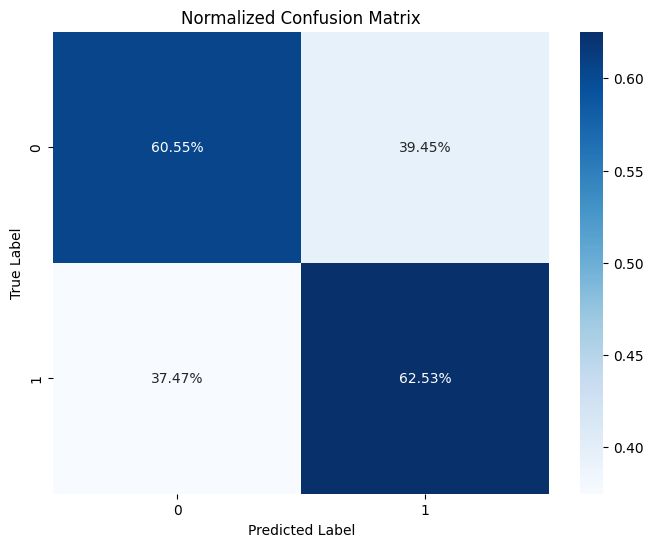

In [15]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(conf_matrix, annot=True, fmt='.2%', cmap='Blues')
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
# Saving the plot - adjust path if needed
plt.savefig('confusion_matrix_logistic.png') 
plt.show() # Display the plot inline
plt.close()

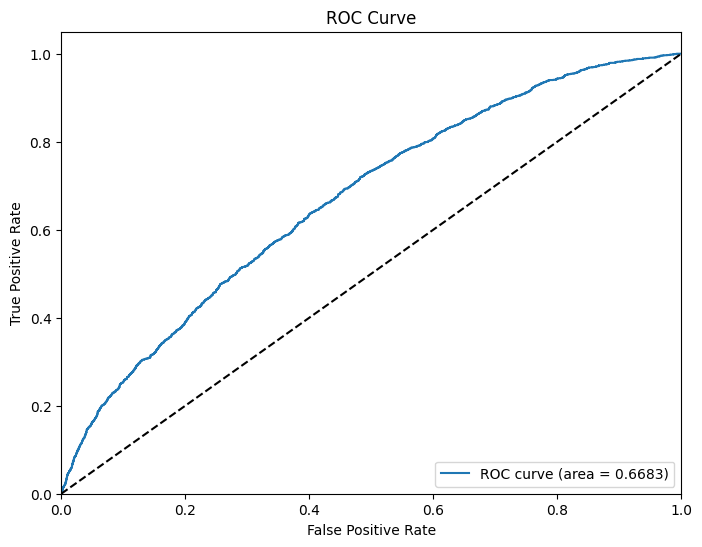

In [16]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label='ROC curve (area = {:.4f})'.format(roc_auc_score(y_test, y_prob)))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
# Saving the plot - adjust path if needed
plt.savefig('roc_curve_logistic.png')
plt.show() # Display the plot inline
plt.close()

## Hyperparameter Tuning

In [17]:
# Hyperparameter tuning
print("Tuning Hyperparameters...")
# Define the parameter grid
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__solver': ['liblinear', 'lbfgs'],
    'classifier__penalty': ['l1', 'l2']
}

# Use only liblinear solver with l1 penalty (lbfgs doesn't support l1)
# Filter the grid for valid combinations
param_grid_filtered = [
    {'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100], 'classifier__solver': ['liblinear'], 'classifier__penalty': ['l1', 'l2']},
    {'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100], 'classifier__solver': ['lbfgs'], 'classifier__penalty': ['l2']}
]

grid_search = GridSearchCV(
    logistic_pipeline,
    param_grid_filtered,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best Parameters: {}".format(grid_search.best_params_))
print("Best ROC AUC Score: {:.4f}".format(grid_search.best_score_))

Tuning Hyperparameters...
Best Parameters: {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best ROC AUC Score: 0.6769


## Evaluate Best Model

In [18]:
# Evaluate the best model
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
y_prob_best = best_model.predict_proba(X_test)[:, 1]

print("Best Model Evaluation:")
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred_best)))
print("Precision: {:.4f}".format(precision_score(y_test, y_pred_best)))
print("Recall: {:.4f}".format(recall_score(y_test, y_pred_best)))
print("F1 Score: {:.4f}".format(f1_score(y_test, y_pred_best)))
print("ROC AUC: {:.4f}".format(roc_auc_score(y_test, y_prob_best)))

print("Classification Report for Best Model:")
print(classification_report(y_test, y_pred_best))

Best Model Evaluation:
Accuracy: 0.6127
Precision: 0.3829
Recall: 0.6298
F1 Score: 0.4763
ROC AUC: 0.6697
Classification Report for Best Model:
              precision    recall  f1-score   support

           0       0.81      0.61      0.69      5212
           1       0.38      0.63      0.48      2023

    accuracy                           0.61      7235
   macro avg       0.60      0.62      0.58      7235
weighted avg       0.69      0.61      0.63      7235



## Visualize Best Model Performance

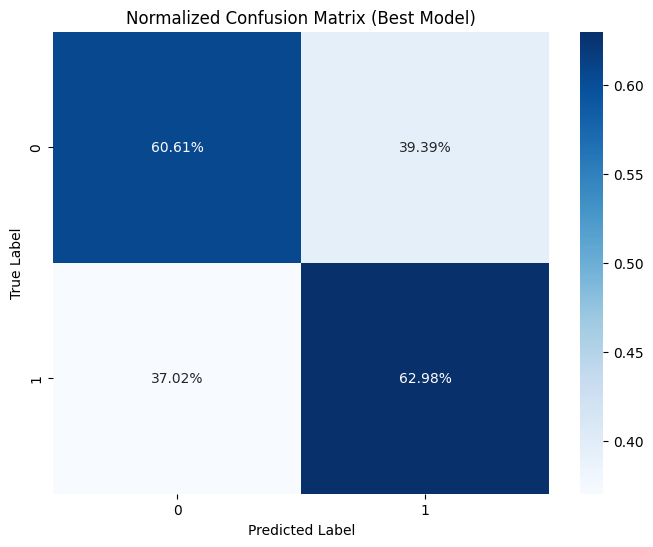

In [19]:
# Plot confusion matrix for best model
plt.figure(figsize=(8, 6))
conf_matrix_best = confusion_matrix(y_test, y_pred_best, normalize='true')
sns.heatmap(conf_matrix_best, annot=True, fmt='.2%', cmap='Blues')
plt.title('Normalized Confusion Matrix (Best Model)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
# Saving the plot - adjust path if needed
plt.savefig('confusion_matrix_logistic_best.png')
plt.show() # Display the plot inline
plt.close()

## Feature Importance

Top 20 Important Features:


,Feature,Importance,Abs_Importance
0,total_transactions,2.356777,2.356777
1,telepass_pay_transactions,-1.493355,1.493355
2,num_months_active,-1.048037,1.048037
3,total_expenditures,0.714327,0.714327
4,broker_id_5,-0.560472,0.560472
5,telepass_pay_expenditures,-0.485283,0.485283
6,telepass_pay_pct,0.284133,0.284133
7,car_brand_SMART,0.277582,0.277582
8,has_telepass_premium_1,0.272959,0.272959
9,price_full,-0.247247,0.247247


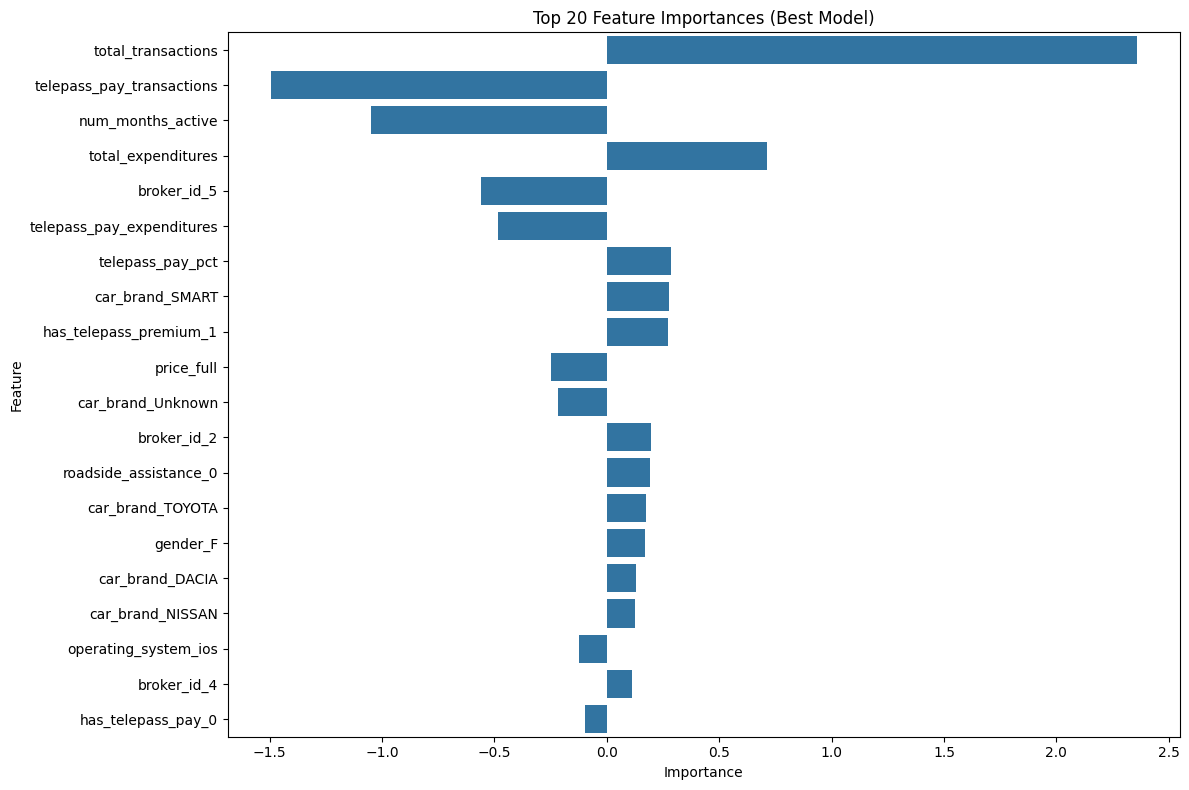

In [20]:
# Feature importance
if hasattr(best_model.named_steps['classifier'], 'coef_'):
    try:
        # Get feature names after preprocessing
        preprocessor_step = best_model.named_steps['preprocessor']
        
        # Numerical features names are straightforward
        num_feature_names = [col for col in numerical_features if col in X_train.columns]
        
        # Get categorical feature names from the OneHotEncoder
        cat_transformer = preprocessor_step.named_transformers_['cat']
        ohe_step = cat_transformer.named_steps['onehot']
        cat_feature_names = ohe_step.get_feature_names_out([col for col in categorical_features if col in X_train.columns])
        
        # Combine feature names
        feature_names = num_feature_names + list(cat_feature_names)
        
        # Get coefficients
        coefficients = best_model.named_steps['classifier'].coef_[0]
        
        # Create a DataFrame to store feature importances
        if len(feature_names) == len(coefficients):
            feature_importance = pd.DataFrame({
                'Feature': feature_names,
                'Importance': coefficients
            })
            
            # Sort by absolute importance
            feature_importance['Abs_Importance'] = feature_importance['Importance'].abs()
            feature_importance = feature_importance.sort_values('Abs_Importance', ascending=False).reset_index(drop=True)
            
            # Display top 20 features
            print("Top 20 Important Features:")
            display(feature_importance.head(20))
            
            # Plot feature importance
            plt.figure(figsize=(12, 8))
            sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
            plt.title('Top 20 Feature Importances (Best Model)')
            plt.tight_layout()
            # Saving the plot - adjust path if needed
            plt.savefig('feature_importance_logistic.png')
            plt.show() # Display the plot inline
            plt.close()
        else:
            print(f"Error: Number of feature names ({len(feature_names)}) does not match number of coefficients ({len(coefficients)}).")

    except Exception as e:
        print(f"Error extracting or plotting feature importance: {e}")
else:
    print("The selected model classifier does not have 'coef_' attribute for feature importance.")

## Model Summary

In [21]:
print("Logistic Regression Model Analysis Completed.")
print("Model Strengths:")
print("1. Interpretability: Logistic regression provides clear insights into feature importance.")
print("2. Efficiency: The model is computationally efficient, which is beneficial for large datasets.")
print("3. Probability Output: The model provides probability scores that can be used for decision making.")

print("Model Weaknesses:")
print("1. Linearity Assumption: Logistic regression assumes a linear relationship between features and the log-odds of the target.")
print("2. Limited Complexity: May not capture complex non-linear relationships in the data.")
print("3. Feature Engineering Dependency: Relies heavily on good feature engineering to perform well.") 

Logistic Regression Model Analysis Completed.
Model Strengths:
1. Interpretability: Logistic regression provides clear insights into feature importance.
2. Efficiency: The model is computationally efficient, which is beneficial for large datasets.
3. Probability Output: The model provides probability scores that can be used for decision making.
Model Weaknesses:
1. Linearity Assumption: Logistic regression assumes a linear relationship between features and the log-odds of the target.
2. Limited Complexity: May not capture complex non-linear relationships in the data.
3. Feature Engineering Dependency: Relies heavily on good feature engineering to perform well.
